**Обучение с учителем: качество модели**

**Описание проекта**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

жно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
<br>
Нужно собрать данные по клиентам по следующим группам: 
- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

In [1]:
!pip install shap

In [2]:
!pip install scikit-learn

In [3]:
!pip install phik

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## Шаг 1. Загрузка данных

### 1.1 Чтение файлов

In [6]:
try:
    data_info = pd.read_csv('/datasets/market_file.csv'  , sep = ",")
except:
    data_info = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv'  , sep = ",")

In [7]:
try:
    data_money = pd.read_csv('/datasets/market_money.csv')
except:
    data_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')

In [8]:
try:
    data_time = pd.read_csv('/datasets/market_time.csv')
except:
    data_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')

In [9]:
try:
    data_money_res = pd.read_csv('/datasets/money.csv'  , sep = ";" , decimal = ",")
except:
    data_money_res = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv'  , sep = ";" , decimal = ",")

### 1.2 Общая информация

####  1.2.1 Таблица data_info

In [10]:
data_info.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [11]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

**Типы данных указаны верно, также данные совпадают с документацией**

####  1.2.2 Таблица data_money

In [12]:
data_money.head(5)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [13]:
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**Типы данных указаны верно, также данные совпадают с документацией**

####  1.2.3 Таблица data_time

In [14]:
data_time.head(5)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [15]:
data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**Типы данных указаны верно, также данные совпадают с документацией**

####  1.2.4 Таблица data_money_res

In [16]:
data_money_res.head(5)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [17]:
data_money_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Изначально тип данных в столбце прибыль был object, исправил на float. Данные совпадают с документацией**

### 1.3 Вывод

1. Произвели выгрузку данных
2. Cверили типы данных, в таблице data_money_res исправили тип данных, в остальных таблицах все сошлось
3. Сверили данные с документацией, все совпало

## Шаг 2. Предобработка данных

### 2.1 Названия столбцов

In [18]:
data_info = data_info.rename(columns = {"Покупательская активность" : "Покупательская_активность" , "Тип сервиса" : "Тип_сервиса" , "Разрешить сообщать" : "Разрешить_сообщать"})

In [19]:
data_info.head(1)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5


In [20]:
data_time = data_time.rename(columns = {"минут" : "Минут"})

In [21]:
data_time.head(1)

,id,Период,Минут
0,215348,текущий_месяц,14


### 2.2 Пропуски

In [22]:
data_info.name = "info"
data_money.name = "money"
data_time.name = "time"
data_money_res.name = "money_res"

In [23]:
def analys_None(*data):
    for item in data:
        print(f"-----{item.name}-----")
        print(item.isna().sum())
        print()

In [24]:
analys_None(data_info , data_money , data_time , data_money_res)

-----info-----
id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

-----money-----
id         0
Период     0
Выручка    0
dtype: int64

-----time-----
id        0
Период    0
Минут     0
dtype: int64

-----money_res-----
id         0
Прибыль    0
dtype: int64



**Пропуски во всех таблицах отсутствуют**

### 2.3 Дубликаты

In [25]:
#Поиск полных дубликатов
def analys_duplicates(*data):
    for item in data:
        print(f"-----{item.name}-----")
        print(len(item[item.duplicated()]))
        print()

In [26]:
analys_duplicates(data_info , data_money , data_time , data_money_res)

-----info-----
0

-----money-----
0

-----time-----
0

-----money_res-----
0



**Полные дубликаты во всех таблицах отсутствуют**

### 2.4 Категариальные переменные(неявные дубликаты)

In [27]:
#Получим названия столбцов с категориальными данными
columns_data_info_cat = data_info.select_dtypes(include = ["object"]).columns

In [28]:
columns_data_money_cat = data_money.select_dtypes(include = ["object"]).columns

In [29]:
columns_data_time_cat = data_time.select_dtypes(include = ["object"]).columns

In [30]:
def analys_cat(col , data):
    print("-" * 20)
    print(data.name)
    print("-" * 20)
    for item in col:
        print(f"{item} - {len(data[item].unique())} , {data[item].unique()}")

In [31]:
analys_cat(columns_data_info_cat , data_info)

--------------------
info
--------------------
Покупательская_активность - 2 , ['Снизилась' 'Прежний уровень']
Тип_сервиса - 3 , ['премиум' 'стандартт' 'стандарт']
Разрешить_сообщать - 2 , ['да' 'нет']
Популярная_категория - 6 , ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Нашли неявный дубликат в таблице "data_info":<br> 'стандартт' и 'стандарт'

In [32]:
data_info["Тип_сервиса"] = data_info["Тип_сервиса"].apply(lambda x: "стандарт" if x == "стандартт" else x)

In [33]:
analys_cat(columns_data_info_cat , data_info)

--------------------
info
--------------------
Покупательская_активность - 2 , ['Снизилась' 'Прежний уровень']
Тип_сервиса - 2 , ['премиум' 'стандарт']
Разрешить_сообщать - 2 , ['да' 'нет']
Популярная_категория - 6 , ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Исправили неявный дубликат

In [34]:
analys_cat(columns_data_money_cat , data_money)

--------------------
money
--------------------
Период - 3 , ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


'препредыдущий_месяц' и 'предыдущий_месяц' это не неявные дубликаты 

In [35]:
data_money["Период"].value_counts()

препредыдущий_месяц    1300
предыдущий_месяц       1300
текущий_месяц          1300
Name: Период, dtype: int64

In [36]:
analys_cat(columns_data_time_cat , data_time)

--------------------
time
--------------------
Период - 2 , ['текущий_месяц' 'предыдцщий_месяц']


граматическая ошибка - "предыдцщий_месяц"

In [37]:
data_time["Период"] = data_time["Период"].apply(lambda x: "предыдущий_месяц" if x == "предыдцщий_месяц" else x)

In [38]:
analys_cat(columns_data_time_cat , data_time)

--------------------
time
--------------------
Период - 2 , ['текущий_месяц' 'предыдущий_месяц']


### 2.5 Вывод

1. Поменяли названия столбцов, чтобы привести их к единому стилю
2. Проверили на наличие пропусков в данных(пропуски во всех таблицах отсутствуют)
3. Проверили на наличие дубликатов в данных(дубликаты во всех таблицах отсутствуют)
4. Проверили на наличие неявных дубликатов в данных(нашли и преобразовали неявные дубликаты в таблице "data_info", также исправили граматическую ошибку в таблице "data_time" ) в остальных таблицах неявных дубликатов нет

## Шаг 3. Исследовательский анализ данных

### 3.1 Общий анализ

In [39]:
data_info.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


В таблице "data_info" все значения выглядят правдоподобно

In [40]:
data_money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


В таблице "data_money" все значения выглядят правдоподобно

In [41]:
data_time.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
Минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


В таблице "data_time" все значения выглядят правдоподобно

In [42]:
data_money_res.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


В таблице "data_money_res" все значения выглядят правдоподобно

### 3.2 Аномалии

#### 3.2.1 Анамалии в таблице data_info

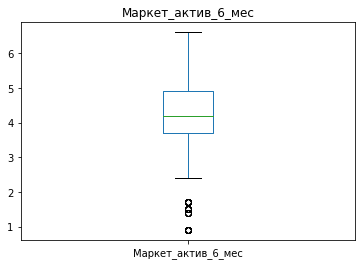

----------------------------------------------------------------


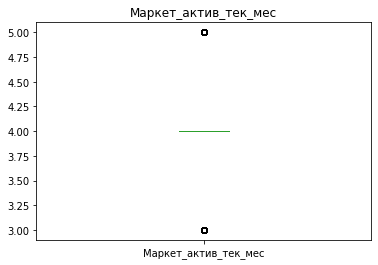

----------------------------------------------------------------


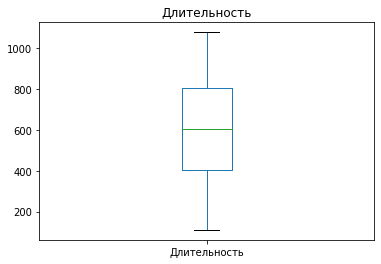

----------------------------------------------------------------


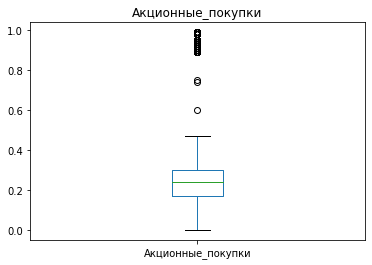

----------------------------------------------------------------


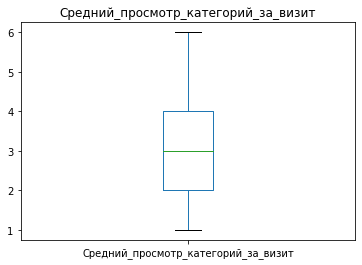

----------------------------------------------------------------


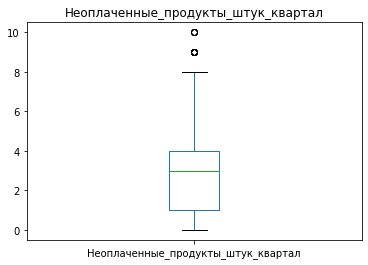

----------------------------------------------------------------


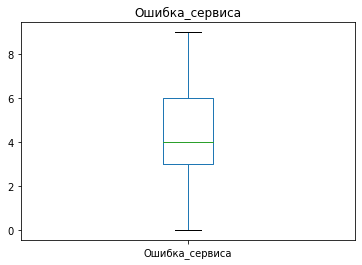

----------------------------------------------------------------


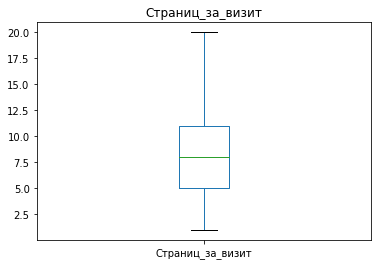

----------------------------------------------------------------


In [43]:
for item in data_info.select_dtypes(exclude=["object"]).columns:
    if item != "id":
        data_info[item].plot(kind = "box");
        plt.title(item)
        plt.show()
        print("-" * 64)
        

***

* __В столбце "Маркет_актив_6_мес" видим выбросы, проанализируем их__

In [44]:

IQR = data_info["Маркет_актив_6_мес"].quantile(.75) - data_info["Маркет_актив_6_мес"].quantile(.25)
Q1 = data_info["Маркет_актив_6_мес"].quantile(.25)
Q3 = data_info["Маркет_актив_6_мес"].quantile(.75)
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR
pr = (len(data_info.loc[data_info["Маркет_актив_6_мес"] < low ]) + len(data_info.loc[data_info["Маркет_актив_6_мес"] > high ])) / len(data_info["Маркет_актив_6_мес"])
print(f'Процент выбросов в стобце Маркет_актив_6_мес от общего количества - {round(pr * 100 , 3)} %')
print(f'Количество выбросов в стобце Маркет_актив_6_мес  - {len(data_info.loc[data_info["Маркет_актив_6_мес"] < low ])}')

Процент выбросов в стобце Маркет_актив_6_мес от общего количества - 2.769 %
Количество выбросов в стобце Маркет_актив_6_мес  - 36


In [45]:
data_info.loc[data_info["Маркет_актив_6_мес"] < low ].head(5)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
30,215378,Снизилась,стандарт,да,1.7,3,488,0.39,Техника для красоты и здоровья,5,1,4,3
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7
38,215386,Снизилась,стандарт,да,1.5,3,495,0.98,Домашний текстиль,2,3,7,5
47,215395,Снизилась,премиум,да,1.5,5,645,0.27,Товары для детей,3,3,6,5
55,215403,Снизилась,премиум,да,1.7,5,771,0.39,Техника для красоты и здоровья,1,8,2,5


* __От 1го до 2х маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев это вполне себе правдоподобно, можем предположить, что данные клиенты не сильно подходили под целевую аудиторию рекламщиков так что им не уделялось внимание. Удалять не будем.__

***

* __В столбце "Маркет_актив_тек_мес" видим выбросы, проанализируем их__

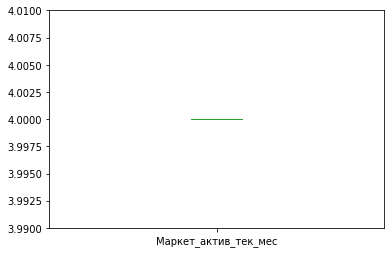

In [46]:
data_info["Маркет_актив_тек_мес"].plot(kind = "box")
plt.ylim(3.99,4.01)
plt.show()

In [47]:
data_info["Маркет_актив_тек_мес"].unique()

array([5, 4, 3])

In [48]:
data_info["Маркет_актив_тек_мес"].value_counts()

4    669
5    323
3    308
Name: Маркет_актив_тек_мес, dtype: int64

* __Исходя из уникальных значений и их количества делаем вывод, что это не выбросы, просто так получилось, что межквартильный размах с с усами забрала на себя 4. Ничего не удалаяем.__

***

* __В столбце "Акционные_покупки" видим выбросы, проанализируем их__

In [49]:

IQR = data_info["Акционные_покупки"].quantile(.75) - data_info["Акционные_покупки"].quantile(.25)
Q1 = data_info["Акционные_покупки"].quantile(.25)
Q3 = data_info["Акционные_покупки"].quantile(.75)
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR
pr = (len(data_info.loc[data_info["Акционные_покупки"] < low ]) + len(data_info.loc[data_info["Акционные_покупки"] > high ])) / len(data_info["Акционные_покупки"])
print(f'Процент выбросов в стобце Акционные_покупки от общего количества - {round(pr * 100 , 3)} %')
print(f'Количество выбросов в стобце Акционные_покупки  - {len(data_info.loc[data_info["Акционные_покупки"] > high ])}')

Процент выбросов в стобце Акционные_покупки от общего количества - 12.923 %
Количество выбросов в стобце Акционные_покупки  - 168


* __В столбце "Акционные_покупки" выбросы находятся в промежутке от 0.6 до 1, это значит, что 168 человек делают свои покупки в большинстве случаях по акциям, это вполне себе правдоподобно. Ничего не удаляем__

***

* __В столбце "Неоплаченные_продукты_штук_квартал" видим выбросы, проанализируем их__

In [50]:
IQR = data_info["Неоплаченные_продукты_штук_квартал"].quantile(.75) - data_info["Неоплаченные_продукты_штук_квартал"].quantile(.25)
Q1 = data_info["Неоплаченные_продукты_штук_квартал"].quantile(.25)
Q3 = data_info["Неоплаченные_продукты_штук_квартал"].quantile(.75)
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR
pr = (len(data_info.loc[data_info["Неоплаченные_продукты_штук_квартал"] < low ]) + len(data_info.loc[data_info["Неоплаченные_продукты_штук_квартал"] > high ])) / len(data_info["Неоплаченные_продукты_штук_квартал"])
print(f'Процент выбросов в стобце Маркет_актив_6_мес от общего количества - {round(pr * 100 , 3)} %')
print(f'Количество выбросов в стобце Маркет_актив_6_мес  - {len(data_info.loc[data_info["Неоплаченные_продукты_штук_квартал"] > high ])}')

Процент выбросов в стобце Маркет_актив_6_мес от общего количества - 1.077 %
Количество выбросов в стобце Маркет_актив_6_мес  - 14


* __В столбце "Акционные_покупки" выбросы находятся в промежутке от 8 до 10, это значит что в столбце "Акционные_покупки" выбросы находятся в промежутке от 0.6 до 1, это значит, что некоторые люди имеют в своих корзинах от 8 до 10 неоплаченных товаров. В этом нет ничего необычного, так что ничего не удаляем__

***

* __В столбцах "Длительность", "Средний_просмотр_категорий_за_визит", "Ошибка_сервиса", "Страниц_за_визит" выбросов нет__

#### 3.2.2 Анамалии в таблице data_money

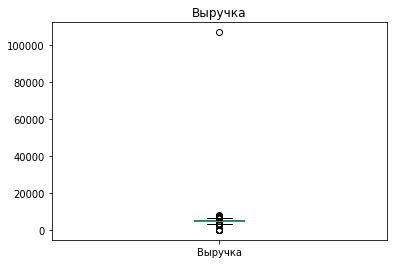

----------------------------------------------------------------


In [51]:
for item in data_money.select_dtypes(exclude=["object"]).columns:
    if item != "id":
        data_money[item].plot(kind = "box");
        plt.title(item)
        plt.show()
        print("-" * 64)

Очевидный выброс со значением больше 100000, можем сразу его удалить

In [52]:
max(data_money["Выручка"])

106862.2

In [53]:
data_money = data_money.loc[data_money["Выручка"] != max(data_money["Выручка"])].copy()

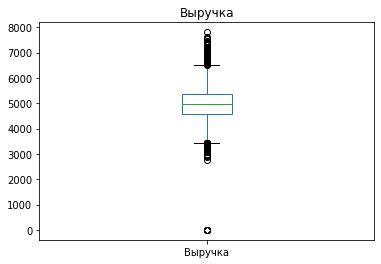

In [54]:
data_money["Выручка"].plot(kind = "box");
plt.title("Выручка")
plt.show()

In [55]:
IQR = data_money["Выручка"].quantile(.75) - data_money["Выручка"].quantile(.25)
Q1 = data_money["Выручка"].quantile(.25)
Q3 = data_money["Выручка"].quantile(.75)
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR
pr = (len(data_money.loc[data_money["Выручка"] < low ]) + len(data_money.loc[data_money["Выручка"] > high ])) / len(data_money["Выручка"])
print(f'Процент выбросов в стобце Выручка от общего количества - {round(pr * 100 , 3)} %')
print(f'Количество выбросов в стобце Выручка  - {len(data_money.loc[data_money["Выручка"] > high ]) + len(data_money.loc[data_money["Выручка"] < low ])}')

Процент выбросов в стобце Выручка от общего количества - 4.463 %
Количество выбросов в стобце Выручка  - 174


* __Выбросы от 6500 до 8000 и от 2500 до 3500 вполне возможны, они не так сильно отличаются от медианы, так что не будем их удалять. Что касается выбросов в 0, с ними мы разберемся позже, когда, будем отберать клиентов с покупательской активностью не менее трёх месяцев. 0 в Выручке возможен, так что это не ошибка__

#### 3.2.3 Анамалии в таблице data_time

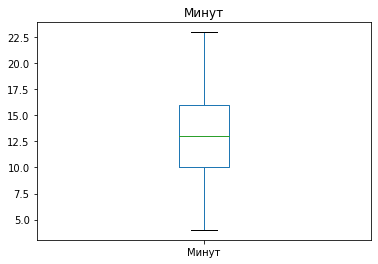

----------------------------------------------------------------


In [56]:
for item in data_time.select_dtypes(exclude=["object"]).columns:
    if item != "id":
        data_time[item].plot(kind = "box");
        plt.title(item)
        plt.show()
        print("-" * 64)

* __Выбросов нет__

#### 3.2.4 Анамалии в таблице data_money_res

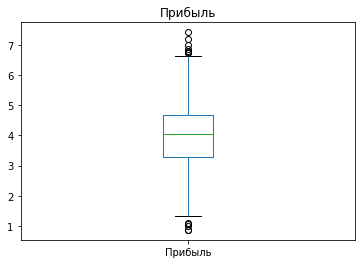

----------------------------------------------------------------


In [57]:
for item in data_money_res.select_dtypes(exclude=["object"]).columns:
    if item != "id":
        data_money_res[item].plot(kind = "box");
        plt.title(item)
        plt.show()
        print("-" * 64)

In [58]:
IQR = data_money_res["Прибыль"].quantile(.75) - data_money_res["Прибыль"].quantile(.25)
Q1 = data_money_res["Прибыль"].quantile(.25)
Q3 = data_money_res["Прибыль"].quantile(.75)
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR
pr = (len(data_money_res.loc[data_money_res["Прибыль"] < low ]) + len(data_money_res.loc[data_money_res["Прибыль"] > high ])) / len(data_money_res["Прибыль"])
print(f'Процент выбросов в стобце Прибыль от общего количества - {round(pr * 100 , 3)} %')
print(f'Количество выбросов в стобце Прибыль  - {len(data_money_res.loc[data_money_res["Прибыль"] > high ]) + len(data_money_res.loc[data_money_res["Прибыль"] < low ])}')

Процент выбросов в стобце Прибыль от общего количества - 0.923 %
Количество выбросов в стобце Прибыль  - 12


* __Выбросы от 7.6 до 8 и от 0.5 до 1.4 вполне возможны, они не так сильно отличаются от медианы, так что не будем их удалять.__

### 3.3 Распределения

#### 3.3.1 Распределения data_info

-----Маркет_актив_6_мес-----


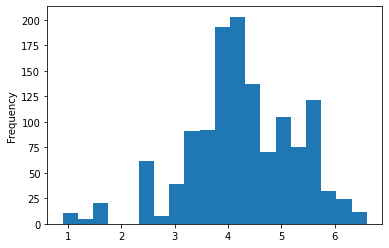

-----Маркет_актив_тек_мес-----


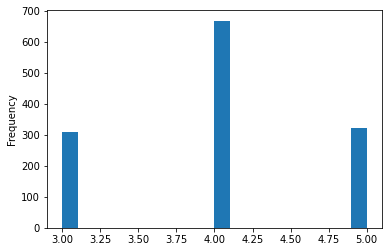

-----Длительность-----


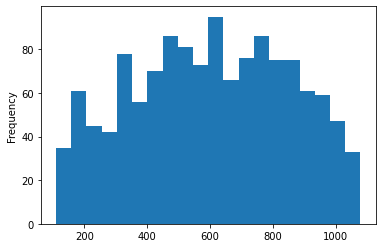

-----Акционные_покупки-----


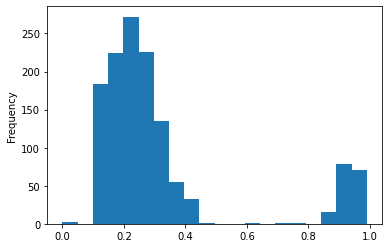

-----Средний_просмотр_категорий_за_визит-----


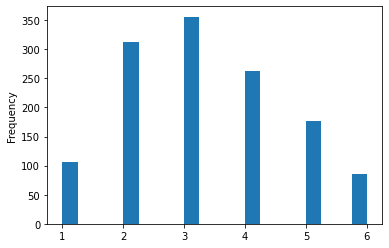

-----Неоплаченные_продукты_штук_квартал-----


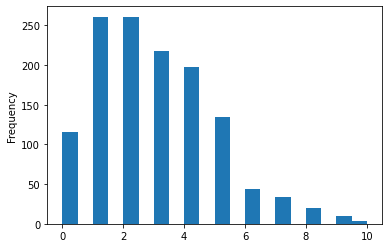

-----Ошибка_сервиса-----


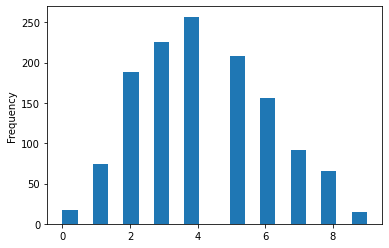

-----Страниц_за_визит-----


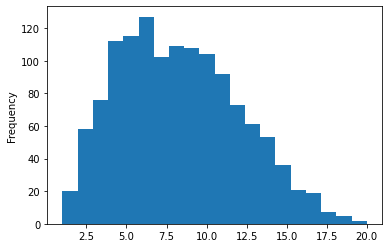

In [59]:
#числовые данные
for item in data_info.select_dtypes(exclude = ["object"]).columns:
    if item != "id":
        print(f"-----{item}-----")
        data_info[item].plot(kind = "hist" , bins = 20);
        plt.show()

По графикам можем заметить, что у столбцов "Маркет_актив_6_мес", "Маркет_актив_тек_мес", "Длительность" и "Акционные_покупки " , график не похож на нормальное распредление. у столбца "Средний_просмотр_категорий_за_визит" , "Страниц_за_визит" и "Неоплаченные_продукты_штук_квартал" графики распределения скошены влево. Столбец "Ошибка_сервиса" имеет нормальное распределение
<br>
Также можем заметить, что у столбцов "Маркет_актив_6_мес" , "Средний_просмотр_категорий_за_визит", "Ошибка_сервиса" и "Неоплаченные_продукты_штук_квартал" есть определенные значения, которые они принмают принимают 

-----Покупательская_активность-----


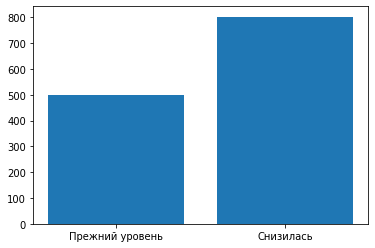

-----Тип_сервиса-----


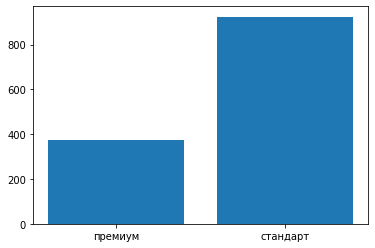

-----Разрешить_сообщать-----


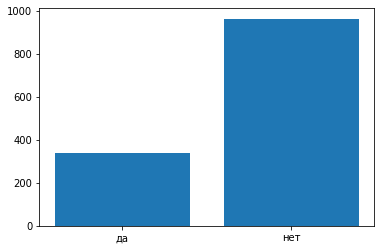

-----Популярная_категория-----


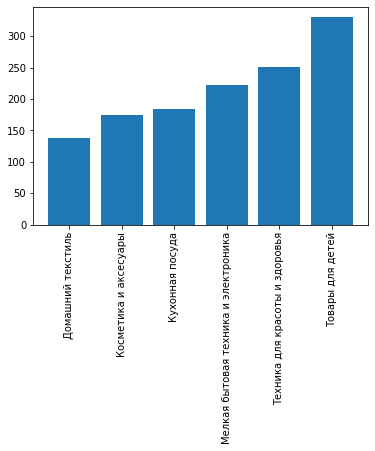

In [60]:
#Категориальные данные
for item in data_info.select_dtypes(include = "object").columns:
        print(f"-----{item}-----")
        unique_values , counts = np.unique(data_info[item] , return_counts = True)
        counts.sort()
        plt.bar(unique_values , counts)
        if item == "Популярная_категория":
            plt.xticks(rotation = 90)
        plt.show()

In [61]:
data_info["Популярная_категория"].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

Можем заметить что в столбцах:
<br>
1. Покупательская_активность - сильно доминируют значения прежний уровень
2. Тип_сервиса - намного больше значений стандарт, чем премиум, что логично, так как за премимум скорее всего надо платить
3. Разрешить_сообщать - намного больше значений да, чем нет, занчит люди чаще соглашаются на рассылки
4. Популярная_категория - категории по популярности располагаются в следующем порядке(от меньшего к большему):
<br>
Домашний текстиль, Косметика и аксесуары, Кухонная посуда, Мелкая бытовая техника и электроника, Техника для красоты и здоровья, Товары для детей


#### 3.3.2 Распределения data_money

-----Выручка-----


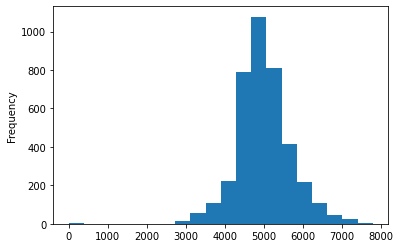

In [62]:
for item in data_money.select_dtypes(exclude = ["object"]).columns:
    if item != "id":
        print(f"-----{item}-----")
        data_money[item].plot(kind = "hist" , bins = 20);
        plt.show()

Распределение похоже на нормально, однако есть выбросы в районе 0

-----Период-----


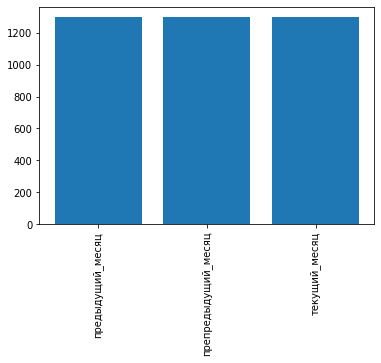

In [63]:
#Категориальные данные
for item in data_money.select_dtypes(include = "object").columns:
        print(f"-----{item}-----")
        unique_values , counts = np.unique(data_money[item] , return_counts = True)
        counts.sort()
        plt.bar(unique_values , counts)
        plt.xticks(rotation = 90)
        plt.show()

In [64]:
counts

array([1299, 1300, 1300])

Значений в периоде по ровну, в каждой категории по 1300( в предыдущем месяце 1299). Распределены равномерно

#### 3.3.3 Распределения data_time

-----Минут-----


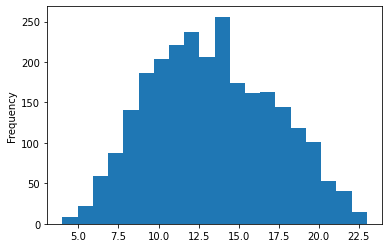

In [65]:
for item in data_time.select_dtypes(exclude = ["object"]).columns:
    if item != "id":
        print(f"-----{item}-----")
        data_time[item].plot(kind = "hist" , bins = 20);
        plt.show()

Распределение похоже на нормальное

-----Период-----


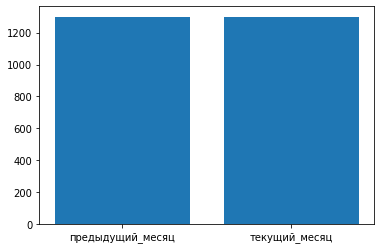

In [66]:
#Категориальные данные
for item in data_time.select_dtypes(include = "object").columns:
        print(f"-----{item}-----")
        unique_values , counts = np.unique(data_time[item] , return_counts = True)
        counts.sort()
        plt.bar(unique_values , counts)
        plt.show()

In [67]:
counts

array([1300, 1300])

Значений в периоде по ровну, в каждой категории по 1300. Данные распределены равномерно

#### 3.3.3 Распределения data_money_res

-----Прибыль-----


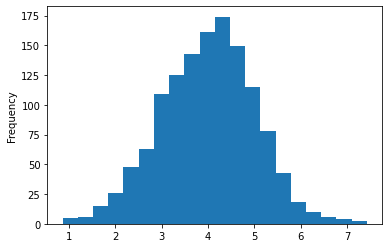

In [68]:
for item in data_money_res.select_dtypes(exclude = ["object"]).columns:
    if item != "id":
        print(f"-----{item}-----")
        data_money_res[item].plot(kind = "hist" , bins = 20);
        plt.show()

График похож на нормальное распределение, но скошен вправо

### 3.4 Отбор клиентов с покупательской активностью не менее трёх месяцев

In [69]:
data_money.head(5)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [70]:
data_money["Период"].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [71]:
# data_money_tmp = data_money.groupby("id")["Выручка"].agg(["sum"]).copy()
# data_money_tmp.head(5)
# data_money_tmp.loc[(data_money_tmp["sum"] == 0)]

In [72]:
data_tmp = data_money.copy()

In [73]:
def make_col_1(items):
    if items["Период"] == "текущий_месяц":
        return items["Выручка"]
        
def make_col_2(items):
    if items["Период"] == "предыдущий_месяц":
        return items["Выручка"]

def make_col_3(items):
    if items["Период"] == "препредыдущий_месяц":
        return items["Выручка"]
        
        

In [74]:
data_tmp["текущий_месяц_выручка"] = data_tmp.apply(make_col_1 , axis = 1)
data_tmp["предыдущий_месяц_выручка"] = data_tmp.apply(make_col_2 , axis = 1)
data_tmp["препредыдущий_месяц_выручка"] = data_tmp.apply(make_col_3 , axis = 1)

In [75]:
data_tmp.head(5)

,id,Период,Выручка,текущий_месяц_выручка,предыдущий_месяц_выручка,препредыдущий_месяц_выручка
0,215348,препредыдущий_месяц,0.0,NaN,NaN,0.0
1,215348,текущий_месяц,3293.1,3293.1,NaN,NaN
2,215348,предыдущий_месяц,0.0,NaN,0.0,NaN
3,215349,препредыдущий_месяц,4472.0,NaN,NaN,4472.0
4,215349,текущий_месяц,4971.6,4971.6,NaN,NaN


In [76]:
data_tmp_1 = data_tmp[["id" , "текущий_месяц_выручка"]].copy()
data_tmp_2 = data_tmp[["id" , "предыдущий_месяц_выручка"]].copy()
data_tmp_3 = data_tmp[["id" , "препредыдущий_месяц_выручка"]].copy()

In [77]:
data_tmp_1.dropna(inplace = True)
data_tmp_2.dropna(inplace = True)
data_tmp_3.dropna(inplace = True)

In [78]:
data_tmp_1.head(5)

,id,текущий_месяц_выручка
1,215348,3293.1
4,215349,4971.6
7,215350,5058.4
9,215351,6610.4
14,215352,5872.5


In [79]:
data_tmp_2.head(5)

,id,предыдущий_месяц_выручка
2,215348,0.0
5,215349,5216.0
8,215350,5457.5
10,215351,6158.0
12,215352,5807.5


In [80]:
data_tmp_3.head(5)

,id,препредыдущий_месяц_выручка
0,215348,0.0
3,215349,4472.0
6,215350,4826.0
11,215351,4793.0
13,215352,4594.0


In [81]:
data_money_new = data_tmp_1.merge(data_tmp_2 , on = "id")

In [82]:
data_money_new = data_money_new.merge(data_tmp_3 , on = "id")

In [83]:
data_money_new

,id,текущий_месяц_выручка,предыдущий_месяц_выручка,препредыдущий_месяц_выручка
0,215348,3293.1,0.0,0.0
1,215349,4971.6,5216.0,4472.0
2,215350,5058.4,5457.5,4826.0
3,215351,6610.4,6158.0,4793.0
4,215352,5872.5,5807.5,4594.0
...,...,...,...,...
1294,216643,4741.7,3664.0,4704.0
1295,216644,5353.0,4729.0,5299.0
1296,216645,5139.2,5160.0,5334.0
1297,216646,5224.6,4923.0,4725.0


In [84]:
data_money_new.loc[(data_money_new["текущий_месяц_выручка"] == 0) | (data_money_new["предыдущий_месяц_выручка"] == 0) | (data_money_new["препредыдущий_месяц_выручка"] == 0)]

,id,текущий_месяц_выручка,предыдущий_месяц_выручка,препредыдущий_месяц_выручка
0,215348,3293.1,0.0,0.0
9,215357,5986.3,0.0,0.0
11,215359,4735.0,0.0,0.0


In [85]:
data_money_new = data_money_new.loc[data_money_new["id"] != 215348]
data_money_new = data_money_new.loc[data_money_new["id"] != 215357]
data_money_new = data_money_new.loc[data_money_new["id"] != 215359]

data_info = data_info.loc[data_info["id"] != 215348]
data_info = data_info.loc[data_info["id"] != 215357]
data_info = data_info.loc[data_info["id"] != 215359]

data_time = data_time.loc[data_time["id"] != 215348]
data_time = data_time.loc[data_time["id"] != 215357]
data_time = data_time.loc[data_time["id"] != 215359]

data_money_res = data_money_res.loc[data_money_res["id"] != 215348]
data_money_res = data_money_res.loc[data_money_res["id"] != 215357]
data_money_res = data_money_res.loc[data_money_res["id"] != 215359]

In [86]:
data_money_res

,id,Прибыль
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
...,...,...
1295,216643,4.44
1296,216644,6.11
1297,216645,3.29
1298,216646,4.03


In [87]:
data_money_new.loc[(data_money_new["текущий_месяц_выручка"] == 0) | (data_money_new["предыдущий_месяц_выручка"] == 0) | (data_money_new["препредыдущий_месяц_выручка"] == 0)]

,id,текущий_месяц_выручка,предыдущий_месяц_выручка,препредыдущий_месяц_выручка


In [88]:
data_money_new.isna().sum()

id                             0
текущий_месяц_выручка          0
предыдущий_месяц_выручка       0
препредыдущий_месяц_выручка    0
dtype: int64

Пропусков также нет

In [89]:
len(data_money_new)

1296

Отобрали клиентов с покупательской активностью не менее трёх месяцев, создали новую таблицу

### 3.5 Вывод

В ходе статистеческого анализа мы выяснили:

1. Во всех таблицах минимальные, средние и медианные значения выглядят правдоподобно.
2. Категориальные значения также выглядят правдоподобно.
3. Проанализировали таблицы на анамалии, удалили их там, где посчитали нужным.
4. Проанализировали распределения во всех столбцах всех таблиц, данных с номральным распределением очень мало, так что коэфициент кореляции Пирсона использовать не будем.
5. Отобрали клиентов с покупательской активностью не менее трёх месяцев, создали новую таблицу



## Шаг 4. Объединение таблиц

In [90]:
data_info.head(5)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


In [91]:
data_money_new.head(5)

,id,текущий_месяц_выручка,предыдущий_месяц_выручка,препредыдущий_месяц_выручка
1,215349,4971.6,5216.0,4472.0
2,215350,5058.4,5457.5,4826.0
3,215351,6610.4,6158.0,4793.0
4,215352,5872.5,5807.5,4594.0
5,215353,5388.5,4738.5,5124.0


In [92]:
data_time.head(5)

,id,Период,Минут
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдущий_месяц,8
6,215351,текущий_месяц,13


In [93]:
data_time["Период"].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [94]:
data_tmp1 = data_time.copy()
def make_col_1_1(items):
    if items["Период"] == "текущий_месяц":
        return items["Минут"]
        
def make_col_2_2(items):
    if items["Период"] == "предыдущий_месяц":
        return items["Минут"]

data_tmp1["текущий_месяц_Минут"] = data_tmp1.apply(make_col_1_1 , axis = 1)
data_tmp1["предыдущий_месяц_Минут"] = data_tmp1.apply(make_col_2_2 , axis = 1)

data_tmp_1_1 = data_tmp1[["id" , "текущий_месяц_Минут"]].copy()
data_tmp_2_2 = data_tmp1[["id" , "предыдущий_месяц_Минут"]].copy()

data_tmp_1_1.dropna(inplace = True)
data_tmp_2_2.dropna(inplace = True)

data_time_new = data_tmp_1_1.merge(data_tmp_2_2 , on = "id")

In [95]:
data_time_new

,id,текущий_месяц_Минут,предыдущий_месяц_Минут
0,215349,10.0,12.0
1,215350,13.0,8.0
2,215351,13.0,11.0
3,215352,11.0,8.0
4,215353,10.0,10.0
...,...,...,...
1292,216643,7.0,14.0
1293,216644,11.0,12.0
1294,216645,18.0,12.0
1295,216646,7.0,18.0


In [96]:
data_time_new.loc[(data_time_new["текущий_месяц_Минут"] == 0) | (data_time_new["предыдущий_месяц_Минут"] == 0)]

,id,текущий_месяц_Минут,предыдущий_месяц_Минут


Преобразовали таблицу data_time

In [97]:
data = data_info.merge(data_money_new , on = "id")
data = data.merge(data_time_new , on = "id")

In [98]:
data

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,текущий_месяц_выручка,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_Минут,предыдущий_месяц_Минут
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10.0,12.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13.0,8.0
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13.0,11.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11.0,8.0
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4741.7,3664.0,4704.0,7.0,14.0
1292,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5353.0,4729.0,5299.0,11.0,12.0
1293,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5139.2,5160.0,5334.0,18.0,12.0
1294,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,5224.6,4923.0,4725.0,7.0,18.0


In [99]:
data.isna().sum()

id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
текущий_месяц_выручка                  0
предыдущий_месяц_выручка               0
препредыдущий_месяц_выручка            0
текущий_месяц_Минут                    0
предыдущий_месяц_Минут                 0
dtype: int64

In [100]:
len(data[data.duplicated()])

0

### 4.1 Вывод

Объединили таблицы "data_info", "data_money_new", "data_time_new" в одну таблицу "data". Проверили на пропуски и дубликаты, все хорошо

## Шаг 5. Корреляционный анализ

In [101]:
arr = data.columns

In [102]:
arr = np.delete(arr, np.where(arr == "id"))


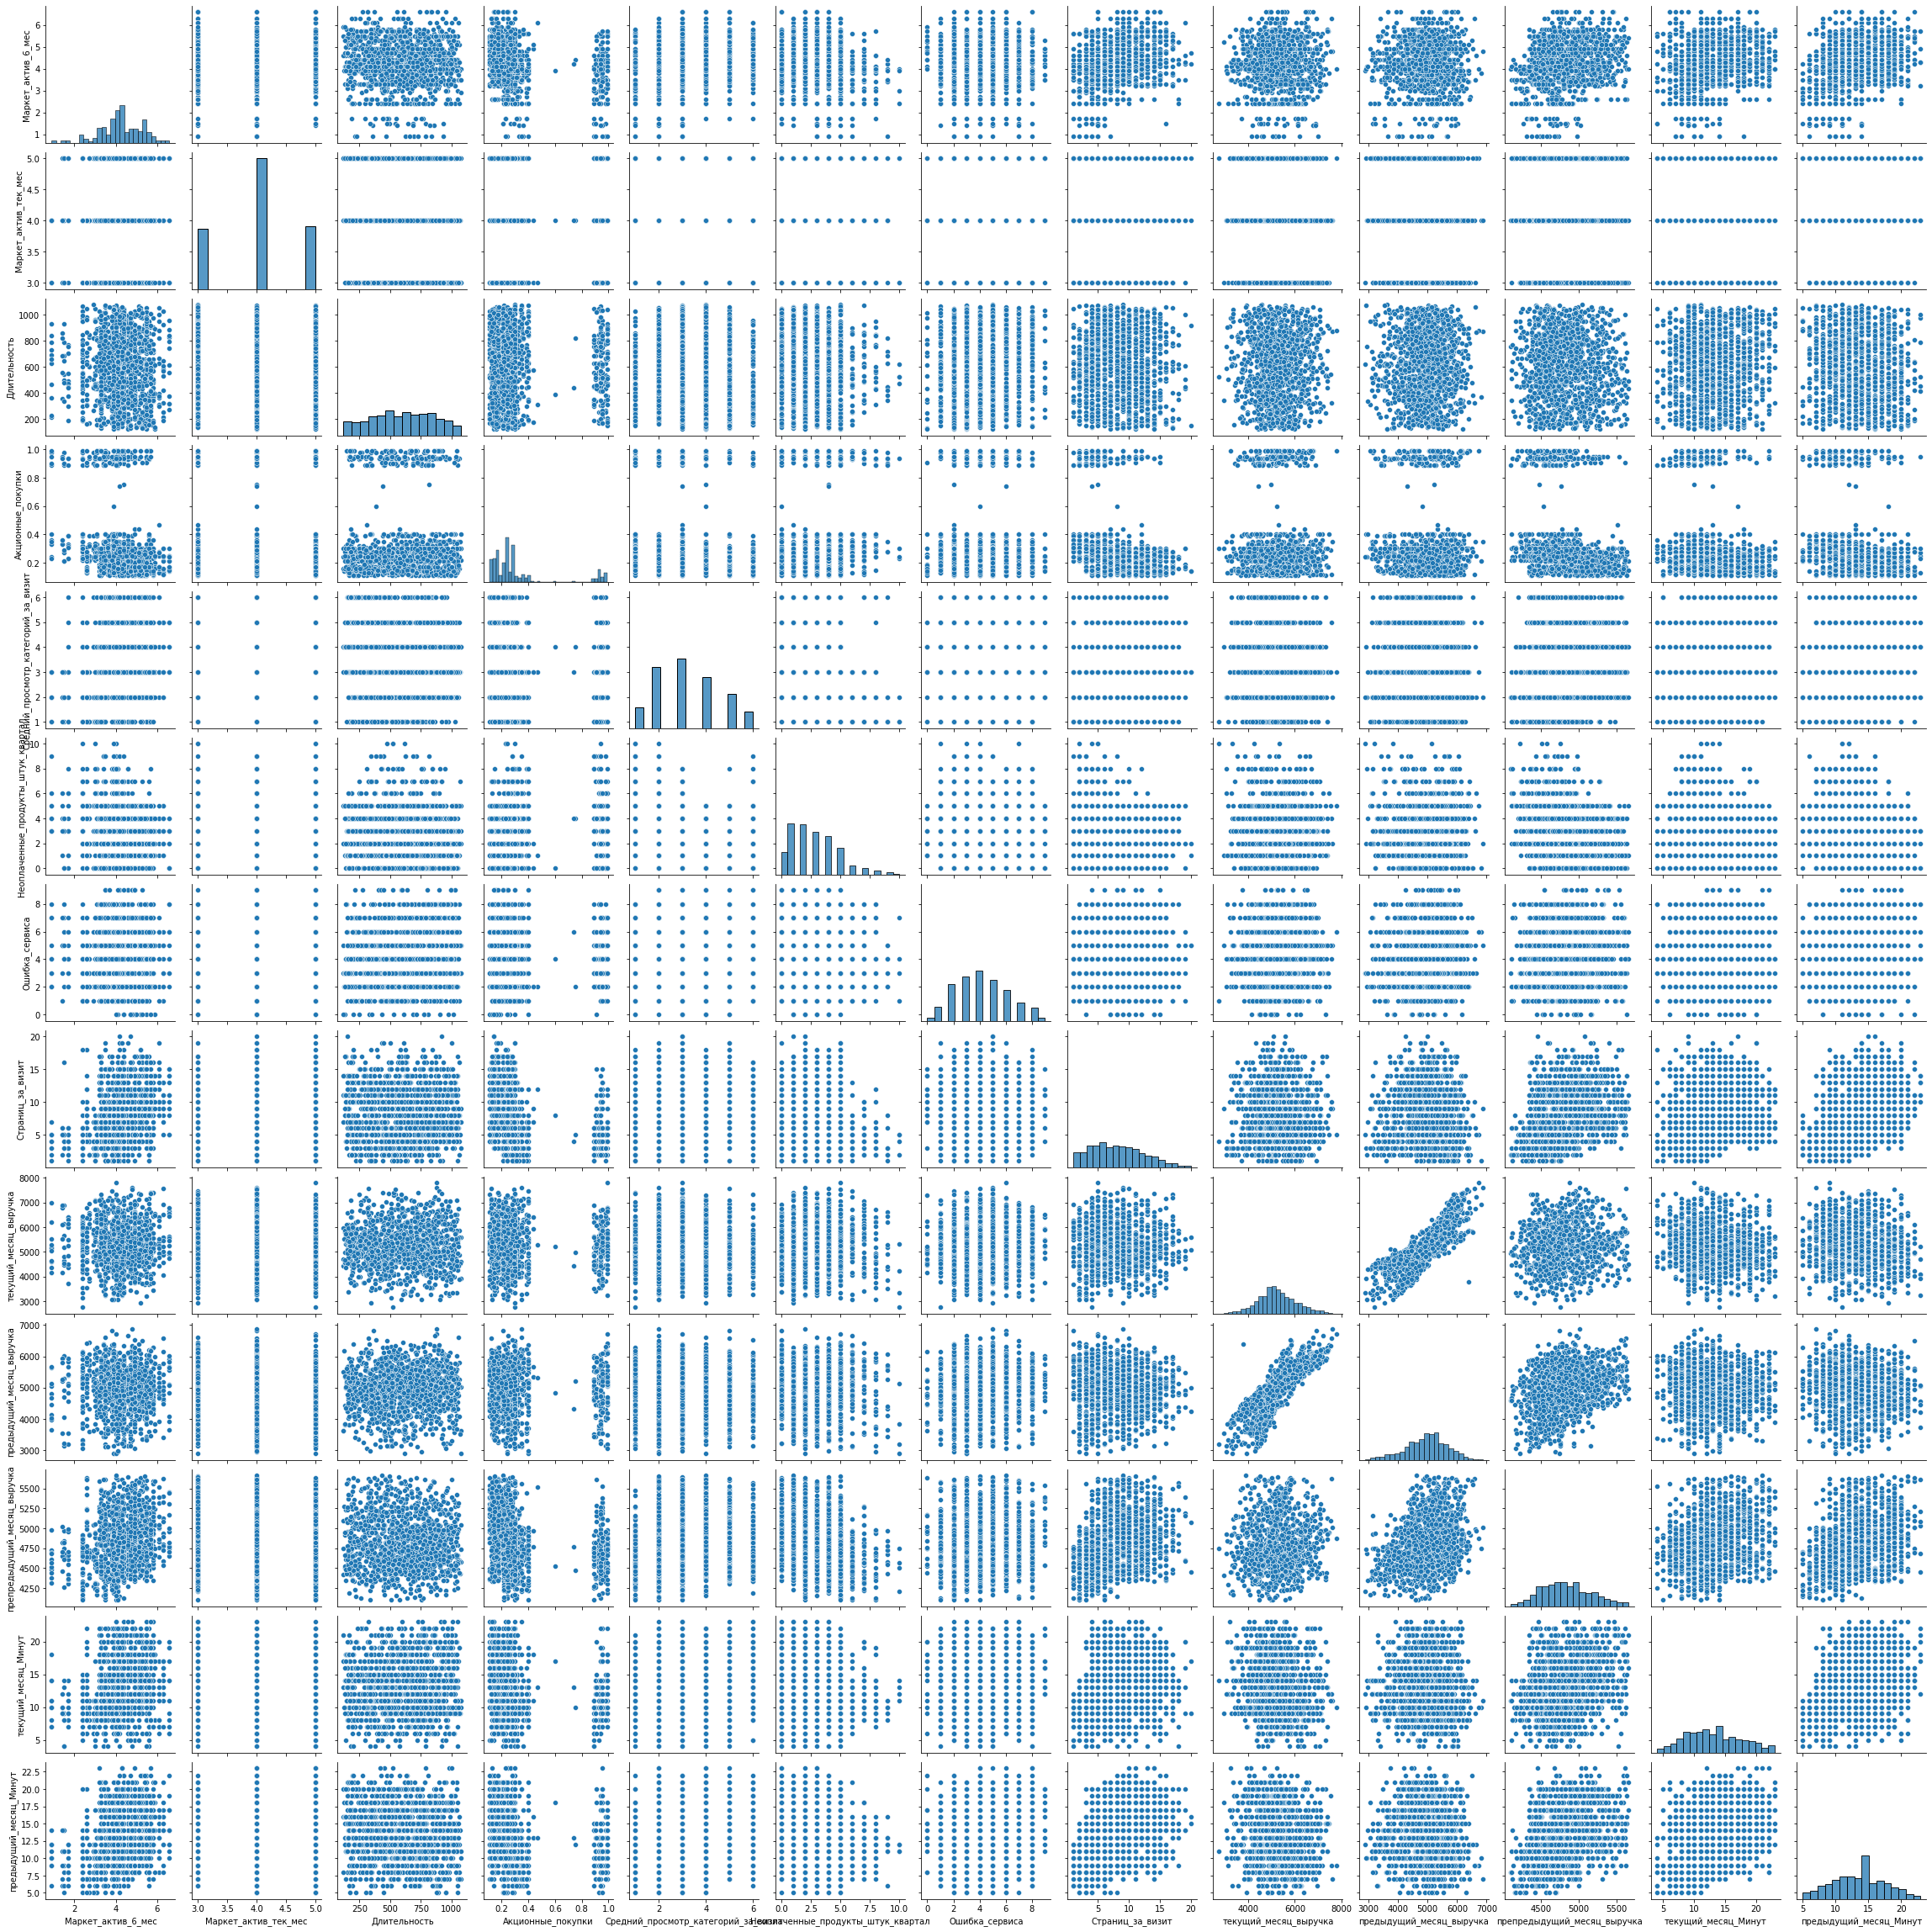

In [103]:
#Долго грузится
sns.pairplot(data[arr]);

Можем сразу заметить сильную линейную свзяь между "текущий_месяц_выручка" и "предыдущий_месяц_выручка" и небольшая свзяь между "препредыдущий_месяц_выручка" и "предыдущий_месяц_выручка"

### 5.1 Кореляция с целевым признаком

Так как целевой признак категориальный и много входных признаков категориальных, то будем использовать phik_matrix

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'текущий_месяц_выручка', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_Минут', 'предыдущий_месяц_Минут']


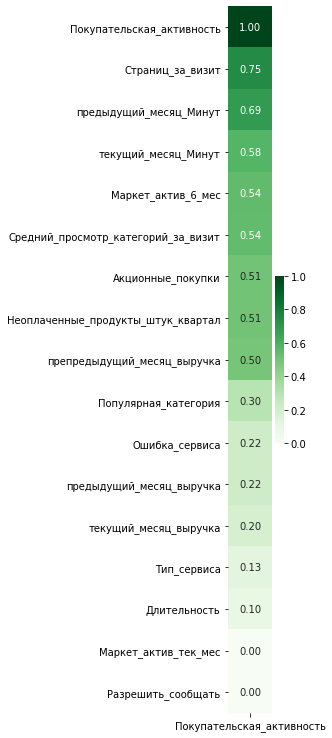

In [104]:
plt.figure(figsize = (1,13))
sns.heatmap(data[arr].phik_matrix()[["Покупательская_активность"]].sort_values(by = "Покупательская_активность" , ascending = False) , annot = True , cmap = "Greens" , fmt = ".2f");

Можем заметить, что:
1. Сильная кореляция с целевым признаком у 'Страниц_за_визит' и 'текущий_месяц_Минут'
2. Средняя кореляция с целевым признаком у "текущий_месяц_Минут" , "Маркет_актив_6_мес" , "Средний_просмотр_категорий_за_визит" , "Акционные_покупки" , "Неоплаченные_продукты_штук_квартал" , "препредыдущий_месяц_выручка"
3. Слабая кореляция с целевым признаком у "Популярная_категория" , "Ошибка_сервиса" , "предыдущий_месяц_выручка" , "текущий_месяц_выручка"
4. Нет кореляции с целевым признаком у "Тип_сервиса", "Длительность", "Маркет_актив_тек_месяц", "разрешать_сообщать"

### 5.2 Кореляция между входными признакками(мультиколлинеарность)

In [105]:
arr = np.delete(arr, np.where(arr == "Покупательская_активность"))

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'текущий_месяц_выручка', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_Минут', 'предыдущий_месяц_Минут']


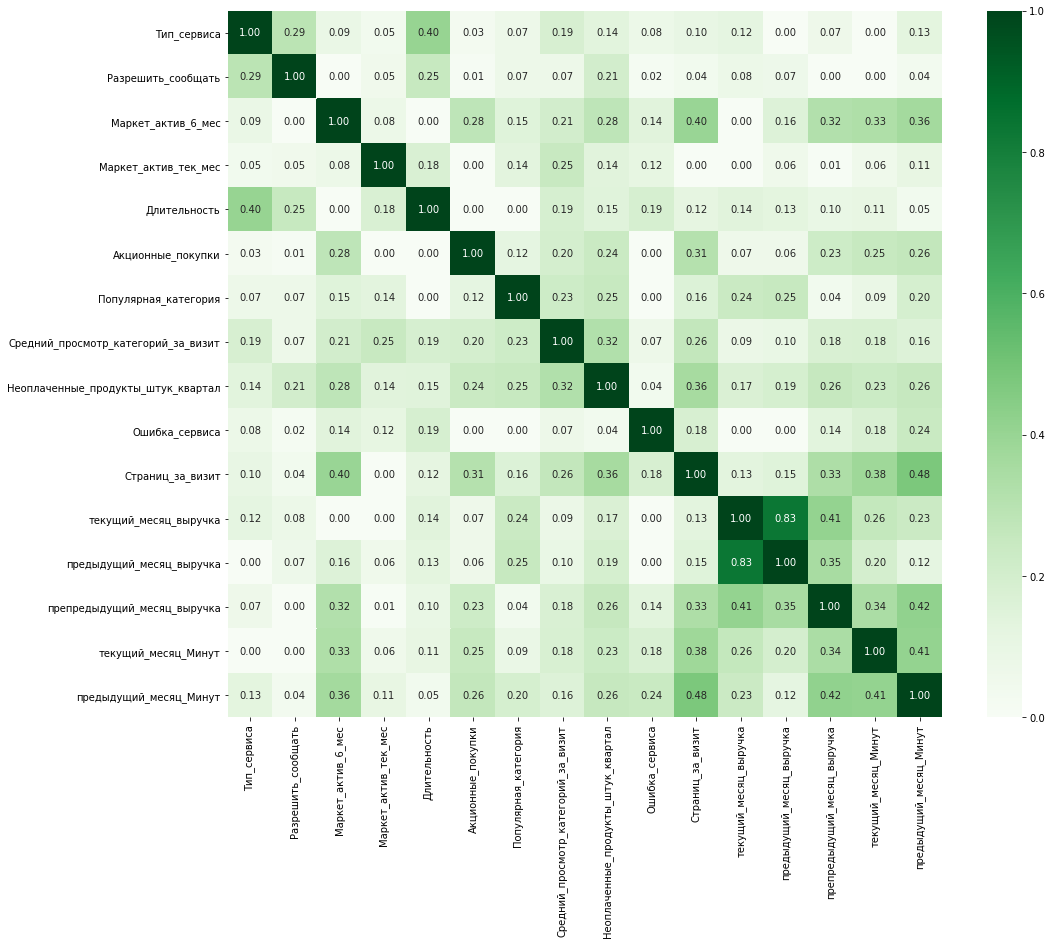

In [106]:
plt.figure(figsize=(16 , 13))
sns.heatmap(data[arr].phik_matrix() , annot = True , cmap = "Greens" , fmt = ".2f");

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Красивый ковёр! Задаёт стиль всему проекту! :D

In [107]:
arr1 = data.select_dtypes(exclude = "object").columns

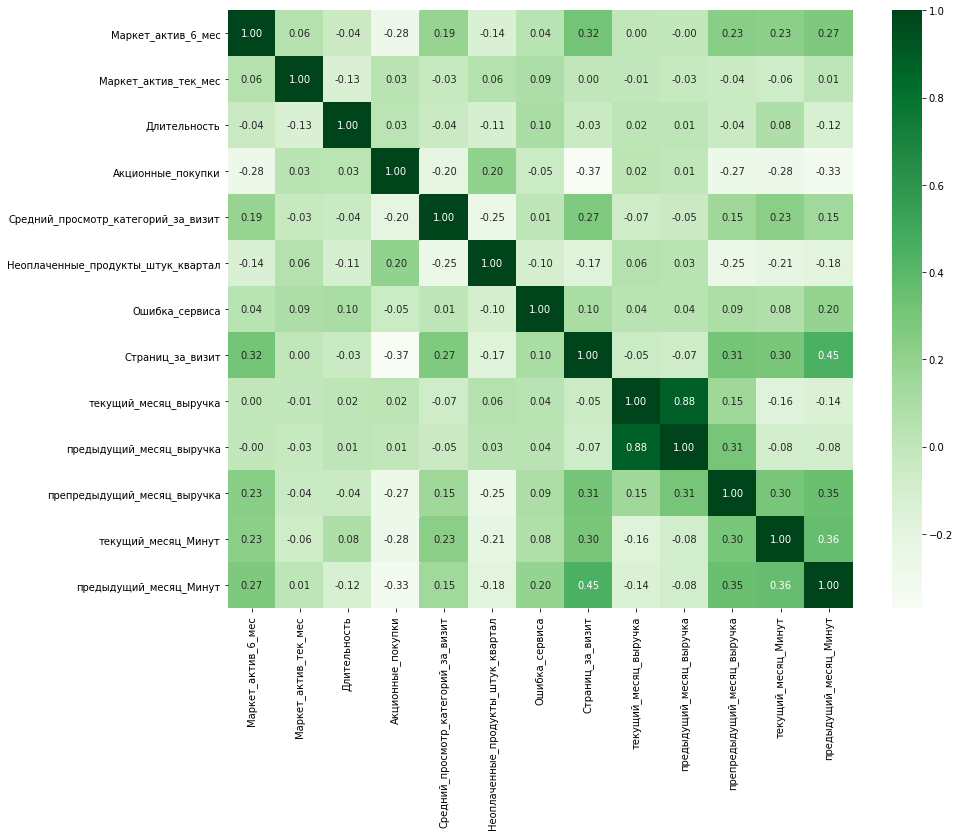

In [108]:
plt.figure(figsize=(14 , 11))
sns.heatmap(data[np.delete(arr1 , np.where(arr1 == "id"))].corr(method="spearman") , annot = True , cmap = "Greens" , fmt = ".2f");

1. Догадки подтвердились, очень сильная кореляция между входными признками "текущий_месяц_выручка" и "предыдущий_месяц_выручка", коэфициент спирмена и фик матрица это показали, 0.88 по спирмену это мультиколлениарность, так что удалим один из признаков
2. Также есть средняя связь между "страниц за визит" - "предыдущий месяц минут" и "тип_сервиса" - "длительность", однако по коэфу Спирмена 0.45 и 0.4 по фик матрице соответственно это не мультиколлениарность, так что удалять ничего не будем
3. У остальных входных признаков взаимосвязей нет или они очень малы

"текущий_месяц_выручка" выручки меньше связан с целевым признаком, чем "предыдущий_месяц_выручка", так что удалим "текущий_месяц_выручка"

In [109]:
data.drop("текущий_месяц_выручка" , axis = 1 , inplace = True)

In [110]:
data.head(1)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_Минут,предыдущий_месяц_Минут
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,10.0,12.0


### 5.3 Вывод

1. Сильная кореляция с целевым признаком у 'Страниц_за_визит' и 'текущий_месяц_Минут'
2. Нет кореляции с целевым признаком у "Тип_сервиса", "Длительность", "Маркет_актив_тек_месяц", "разрешать_сообщать"
3. Нашли мультиколлениарность между входными признаками "текущий_месяц_выручка" и "предыдущий_месяц_выручка", У остальных входных признаков взаимосвязей нет или они очень малы
4. Удалили столбец "текущий_месяц_выручка", чтобы избавиться от мультиколлениарности

## Шаг 6. Использование пайплайнов

In [111]:
X = data.drop(["Покупательская_активность" , "id"] , axis = 1)

In [112]:
y = data["Покупательская_активность"].copy()

In [113]:
X.head(5)

,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_Минут,предыдущий_месяц_Минут
0,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,10.0,12.0
1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,13.0,8.0
2,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,13.0,11.0
3,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,11.0,8.0
4,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,10.0,10.0


In [114]:
y.head(5)

0    Снизилась
1    Снизилась
2    Снизилась
3    Снизилась
4    Снизилась
Name: Покупательская_активность, dtype: object

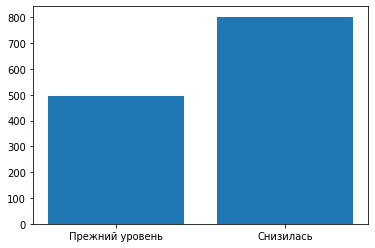

In [115]:
val , k = np.unique(y , return_counts = True)
k.sort()
plt.bar(val,k);

Закодируем целевой признак 

In [116]:
y = y.apply(lambda x: 1 if x=="Прежний уровень" else 0)

In [117]:
y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: Покупательская_активность, dtype: int64

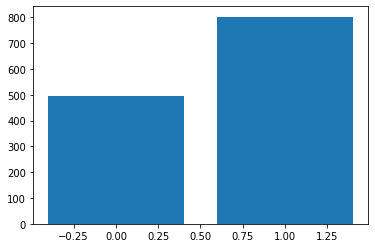

In [118]:
val , k = np.unique(y , return_counts = True)
k.sort()
plt.bar(val,k);

### 6.1 Разбивка данных

In [119]:
ran_st = 42

In [120]:
X_train , X_test , y_train , y_test = train_test_split(X , y , random_state = ran_st , stratify = y , test_size = 0.25)

In [121]:
X_train.shape ,X_test.shape

((972, 15), (324, 15))

In [122]:
y_train.shape , y_test.shape

((972,), (324,))

Размерность совпадает

In [123]:
X_train.head(5)

,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_Минут,предыдущий_месяц_Минут
409,стандарт,нет,5.7,4,565,0.14,Домашний текстиль,5,1,4,12,4252.0,5023.0,18.0,12.0
1273,стандарт,да,3.4,5,351,0.24,Кухонная посуда,5,1,6,8,4337.0,4949.0,13.0,15.0
24,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,5253.5,4715.0,9.0,8.0
38,стандарт,да,3.1,4,152,0.33,Косметика и аксесуары,6,4,2,5,4254.0,4549.0,12.0,8.0
633,стандарт,да,5.5,5,541,0.17,Мелкая бытовая техника и электроника,4,1,6,5,5388.0,5223.0,11.0,12.0


In [124]:
y_train.head(5)

409     1
1273    1
24      0
38      0
633     1
Name: Покупательская_активность, dtype: int64

In [125]:
ohe_columns = list(X_train.select_dtypes(include = "object").columns)

In [126]:
num_columns = list(X_train.select_dtypes(exclude = "object").columns)

In [127]:
ohe_columns

['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']

In [128]:
num_columns

['Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит',
 'предыдущий_месяц_выручка',
 'препредыдущий_месяц_выручка',
 'текущий_месяц_Минут',
 'предыдущий_месяц_Минут']

### 6.1 Создание пайплайна

In [129]:
ohe_pipe = Pipeline([
    ("ohe" , OneHotEncoder(drop = "first" , handle_unknown = "error"))
]
)

In [130]:
data_preprocessor = ColumnTransformer(
    [
        ("ohe" , ohe_pipe , ohe_columns),
        ("num" , MinMaxScaler() , num_columns) , 
    ],
    remainder = "passthrough"
                                     )

In [131]:
pipe_final = Pipeline(
    [
        ("preprocessor" , data_preprocessor),
        ("models" , DecisionTreeClassifier(random_state = ran_st))
    ]
)

In [132]:
paaram_grid = [
    #Деревья
    {
        "models" : [DecisionTreeClassifier(random_state=ran_st)],
        "models__max_depth" : range(2,20),
        "models__max_features" : range(2,20),
        "preprocessor__num" : [StandardScaler(), MinMaxScaler(), RobustScaler(),  'passthrough']
    },
    #ближайшие соседи
    {
        "models" : [KNeighborsClassifier()],
        "models__n_neighbors" : range(2,30),
        "models__metric" : ["euclidean" , "cityblock"],
        "preprocessor__num" : [StandardScaler(), MinMaxScaler(), RobustScaler(),  'passthrough']
    },
    #Линейная Регрессия
    {
        'models': [LogisticRegression(random_state=ran_st, solver='liblinear', penalty='l1')],
        "models__C" : range(1,5),
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        "models" : [SVC(probability = True)],
        "models__kernel" : ["linear", "poly", "rbf", "sigmoid"],
        "models__degree" : range(2 , 7),
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
        
    }
    
]

In [133]:
randomize_search = RandomizedSearchCV(
    pipe_final,
    paaram_grid,
    cv = 5,
    scoring = "roc_auc",
    random_state=ran_st,
    n_jobs=-1,
    n_iter=200
)

    

In [134]:
randomize_search.fit(X_train , y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['Тип_сервиса',
                                                                                'Разрешить_сообщать',
                                                                                'Популярная_категория']),
                                                                              ('num',
                                                                               MinMaxScaler(),
                       

In [135]:
#print('Лучшая модель и её параметры:\n\n', randomize_search.best_estimator_)
#print ('Метрика лучшей модели на тренировочной выборке:', randomize_search.best_score_)

In [136]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', 1000)

In [137]:
result = pd.DataFrame(randomize_search.cv_results_)
with pd.option_context('max_colwidth', 3000):
    display(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score').head(10))

,rank_test_score,param_models,mean_test_score,params
37,1,SVC(probability=True),0.915152,"{'preprocessor__num': StandardScaler(), 'models__kernel': 'rbf', 'models__degree': 3, 'models': SVC(probability=True)}"
170,2,KNeighborsClassifier(),0.912749,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 14, 'models__metric': 'cityblock', 'models': KNeighborsClassifier()}"
198,3,SVC(probability=True),0.911749,"{'preprocessor__num': RobustScaler(), 'models__kernel': 'rbf', 'models__degree': 5, 'models': SVC(probability=True)}"
151,3,SVC(probability=True),0.911749,"{'preprocessor__num': RobustScaler(), 'models__kernel': 'rbf', 'models__degree': 2, 'models': SVC(probability=True)}"
172,5,KNeighborsClassifier(),0.911266,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 26, 'models__metric': 'euclidean', 'models': KNeighborsClassifier()}"
177,6,KNeighborsClassifier(),0.907743,"{'preprocessor__num': RobustScaler(), 'models__n_neighbors': 18, 'models__metric': 'euclidean', 'models': KNeighborsClassifier()}"
25,7,KNeighborsClassifier(),0.906825,"{'preprocessor__num': RobustScaler(), 'models__n_neighbors': 24, 'models__metric': 'cityblock', 'models': KNeighborsClassifier()}"
181,8,KNeighborsClassifier(),0.904485,"{'preprocessor__num': RobustScaler(), 'models__n_neighbors': 12, 'models__metric': 'euclidean', 'models': KNeighborsClassifier()}"
173,9,SVC(probability=True),0.903635,"{'preprocessor__num': MinMaxScaler(), 'models__kernel': 'linear', 'models__degree': 4, 'models': SVC(probability=True)}"
6,9,SVC(probability=True),0.903635,"{'preprocessor__num': MinMaxScaler(), 'models__kernel': 'linear', 'models__degree': 5, 'models': SVC(probability=True)}"


In [138]:
v = result.loc[173 , "params"]

In [139]:
#model = randomize_search.best_estimator_.named_steps.models
ml = randomize_search.estimator.set_params(**v)

Выбрал модель с линейным ядром, чтобы потом можно было визуализировать влияние признаков с помощью библиотеки shap, сделал так по совету преподавателя из обсуждения, так как shap не работает с нелинейным ядром

### Проверка

In [140]:
type(ml["models"])

sklearn.svm._classes.SVC

In [141]:
type(randomize_search.best_estimator_.named_steps.models)

sklearn.svm._classes.SVC

In [142]:
type(randomize_search.best_estimator_)

sklearn.pipeline.Pipeline

In [143]:
type(randomize_search.best_estimator_['models'])

sklearn.svm._classes.SVC

### Проверка закончилась

In [144]:
X_test.head(3)

,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_Минут,предыдущий_месяц_Минут
87,премиум,нет,3.4,5,448,0.28,Товары для детей,4,2,2,7,5484.0,4551.0,9.0,9.0
1223,премиум,да,4.5,4,482,0.25,Косметика и аксесуары,3,2,2,9,5567.0,5483.0,22.0,8.0
1059,стандарт,да,5.1,4,602,0.23,Товары для детей,2,2,8,9,4857.0,4775.0,15.0,17.0


In [145]:
ml.fit(X_train , y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_визит',
           

In [146]:
X_test_good = ml.named_steps.preprocessor.transform(X_test)

In [147]:
X_test_good[0]

array([0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.43859649, 1.        , 0.34133612,
       0.19318182, 0.6       , 0.2       , 0.22222222, 0.31578947,
       0.64560686, 0.28945687, 0.26315789, 0.22222222])

In [148]:
cols_name = ['ohe__Тип_сервиса_стандарт', 'ohe__Разрешить_сообщать_нет',
       'ohe__Популярная_категория_Косметика и аксесуары',
       'ohe__Популярная_категория_Кухонная посуда',
       'ohe__Популярная_категория_Мелкая бытовая техника и электроника',
       'ohe__Популярная_категория_Техника для красоты и здоровья',
       'ohe__Популярная_категория_Товары для детей',
       'num__Маркет_актив_6_мес', 'num__Маркет_актив_тек_мес',
       'num__Длительность', 'num__Акционные_покупки',
       'num__Средний_просмотр_категорий_за_визит',
       'num__Неоплаченные_продукты_штук_квартал', 'num__Ошибка_сервиса',
       'num__Страниц_за_визит', 'num__предыдущий_месяц_выручка',
       'num__препредыдущий_месяц_выручка', 'num__текущий_месяц_Минут',
       'num__предыдущий_месяц_Минут']

В более поздних версиях sklearn названия признаков можно достать так:

In [149]:
#X_test_good_named = pd.DataFrame(X_test_good, columns = [x for x in ml.named_steps.preprocessor.get_feature_names_out()])

В более поздних нашел вспомогательную функцию

In [150]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: 
            names = raw_col_name
        if isinstance(names,np.ndarray): 
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [151]:
get_column_names_from_ColumnTransformer(ml.named_steps.preprocessor)

['x0_стандарт',
 'x1_нет',
 'x2_Косметика и аксесуары',
 'x2_Кухонная посуда',
 'x2_Мелкая бытовая техника и электроника',
 'x2_Техника для красоты и здоровья',
 'x2_Товары для детей']

In [152]:
X_test_good_named = pd.DataFrame(X_test_good, columns = [x for x in cols_name])

In [153]:
ml.named_steps.preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Тип_сервиса', 'Разрешить_сообщать',
                                  'Популярная_категория']),
                                ('num', MinMaxScaler(),
                                 ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес',
                                  'Длительность', 'Акционные_покупки',
                                  'Средний_просмотр_категорий_за_визит',
                                  'Неоплаченные_продукты_штук_квартал',
                                  'Ошибка_сервиса', 'Страниц_за_визит',
                                  'предыдущий_месяц_выручка',
                                  'препредыдущий_месяц_выручка',
                                  'текущий_месяц_Минут',
                                  'пред

In [154]:
X_test_good_named.head(3)

,ohe__Тип_сервиса_стандарт,ohe__Разрешить_сообщать_нет,ohe__Популярная_категория_Косметика и аксесуары,ohe__Популярная_категория_Кухонная посуда,ohe__Популярная_категория_Мелкая бытовая техника и электроника,ohe__Популярная_категория_Техника для красоты и здоровья,ohe__Популярная_категория_Товары для детей,num__Маркет_актив_6_мес,num__Маркет_актив_тек_мес,num__Длительность,num__Акционные_покупки,num__Средний_просмотр_категорий_за_визит,num__Неоплаченные_продукты_штук_квартал,num__Ошибка_сервиса,num__Страниц_за_визит,num__предыдущий_месяц_выручка,num__препредыдущий_месяц_выручка,num__текущий_месяц_Минут,num__предыдущий_месяц_Минут
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.438596,1.0,0.341336,0.193182,0.6,0.2,0.222222,0.315789,0.645607,0.289457,0.263158,0.222222
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.631579,0.5,0.376827,0.159091,0.4,0.2,0.222222,0.421053,0.666837,0.884984,0.947368,0.166667
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.736842,0.5,0.502088,0.136364,0.2,0.2,0.888889,0.421053,0.485228,0.432588,0.578947,0.666667


In [155]:
y_pred = ml.predict(X_test)

In [156]:
print("accuracy_score:" , round(accuracy_score(y_test , y_pred) , 3))

accuracy_score: 0.873


In [157]:
print("roc_auc_score:" , round(roc_auc_score(y_test , ml.predict_proba(X_test)[: , 1]) , 3))

roc_auc_score: 0.883


In [158]:
print("recall_score:" , round(recall_score(y_test , y_pred) , 3))

recall_score: 0.96


In [159]:
print("precision_score:" , round(precision_score(y_test , y_pred) , 3))

precision_score: 0.853


In [160]:
print("f1_score:" , round(f1_score(y_test , y_pred) , 3))

f1_score: 0.904


### 6.3 Вывод

Мы построили пайплайн и обучали модели с разными гиперпараматрами. В итоге лучший результат по метрике roc_auc дала модель SVC() с гипер парамаетрами: 'models__kernel': 'linear' и масштабируемость с помощью MinMax(), метрику roc_auc выбрали, так как она лучше всего учитывает тонкости наших данных. В итоге у нашей моедли на тестовых данных следующие результаты:

1. accuracy_score: 0.873
2. roc_auc_score: 0.847
3. recall_score: 0.96
4. precision_score: 0.853
5. f1_score: 0.904

## Шаг 7. Анализ важности признаков

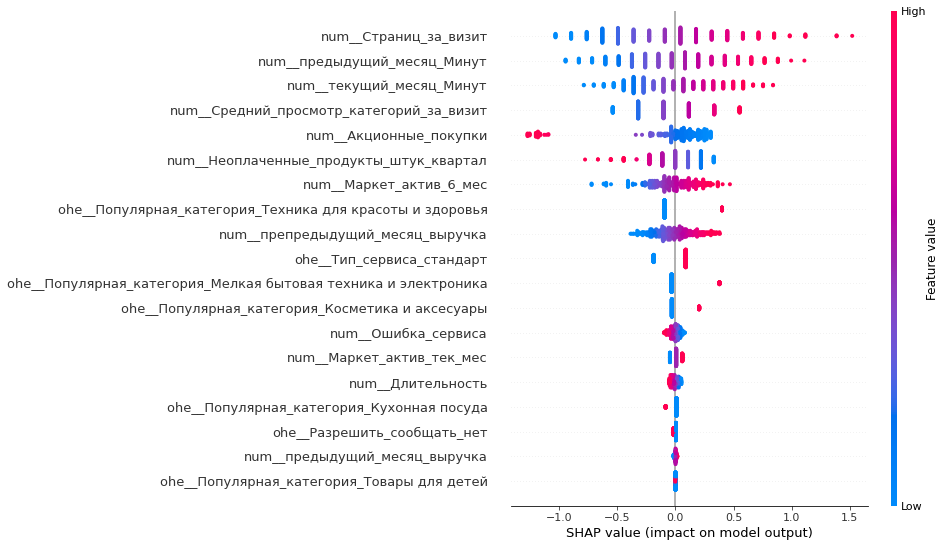

In [162]:
shap.plots.beeswarm(shap_values , max_display=20) 

Визуализации вклада признаков в каждое предсказание модели

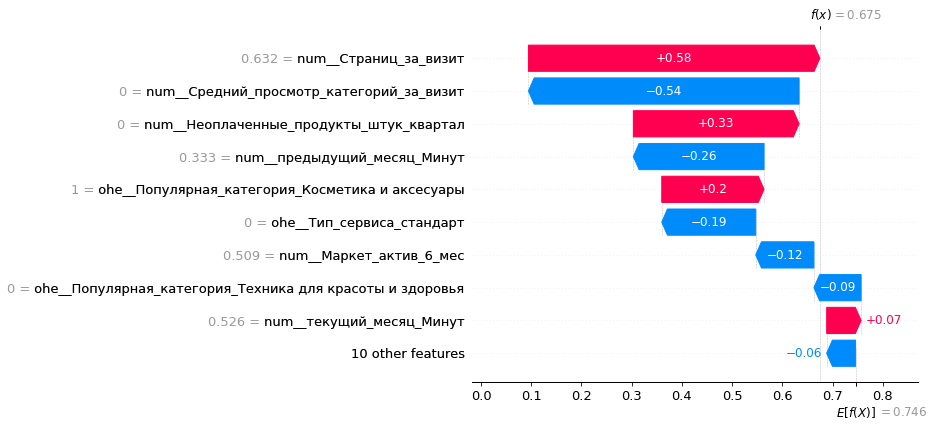

In [163]:
shap.plots.waterfall(shap_values[10]) 

Визуализаация для индивидуального наблюдения в датасете

### 7.1 Вывод

* __Признаки мало значимые для модели(от менее значимых к более значимым):__ <br>
    1. Популярная_категория_Товары для детей
    2. предыдущий_месяц_выручка
    3. Разрешить_сообщать_нет
    4. Популярная_категория_Кухонная посуда
    5. Длительность
    6. num__Маркет_актив_тек_мес
    7. num__Ошибка_сервиса


* __Признаки сильнее всего влияющие на целевой признак(от более значимых к менее значимым):__ <br>
    1. Страниц_за_визит
    2. предыдущий_месяц_Минут
    3. текущий_месяц_Минут
    4. Средний_просмотр_категорий_за_визит
    5. Акционные_покупки
    6. num__Неоплаченные_продукты_штук_квартал
    

* __Данные наблюдения можно использовать при моделировании и принятии бизнес-решений следующим образом:__
    1. Исходя из анализа малозначимых признаов, можно сделать вывод, что на покупательмкую актиность почти не влияют технические сбои в магазине, то есть не стоит вкладывать очень большие деньги в то, чтобы моментально решать проблемы с сервисом. Также можно отметить, что на покупательмкую актиность практически не влияет маркетинговая активность, то есть большие затраты на маркетиннг, направленный на конкретных пользоавтелей (через почту и тд) также не орпавданы, пользователям это не нужно(сейчас редко кто читает почту). Также не влияет на покупательмкую актиность не влияет давность регистрации покупателя на сайте, то есть новые пользователи и старые одинаково покупают.
    2. Исходя из анализа признаов, которые сильно влияют на покупательмкую актиность, можно сделать вывод, что больше всего на покупательмкую актиность влияет среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, что логично, чем больше пользователей просмторел страниц, товаров, тем больше вероятность того, что ему что-то понравится и он это купит, и наоборот, то есть для повышения покупательской активности слудует придумать способ, чтобы пользователь за визит смог увидетькак можно больше товаров, как вариант можно уменьшить эконки товаровб чтобы пользователей видел за раз больше товаров. Также можно отметить, что на покупательмкую актиность сильно влияют предыдущий_месяц_Минут, текущий_месяц_Минут, Средний_просмотр_категорий_за_визит, это также относится к предыдущим рассуждениям, чем больше пользователь проводит время на сайте, тем вероятнее он что-то купит. Также не влияет на покупательмкую актиность влияют Акционные_покупки, это связано с тем, что некоторые пользователи очень часто покупают товары по скидкам из-за их выгоды, если данным пользователям прежлагать часто выгодные товары, то они будут поддерживать покупательскую актиность.
      

## Шаг 8. Сегментация покупателей

In [164]:
X_test_good_named

,ohe__Тип_сервиса_стандарт,ohe__Разрешить_сообщать_нет,ohe__Популярная_категория_Косметика и аксесуары,ohe__Популярная_категория_Кухонная посуда,ohe__Популярная_категория_Мелкая бытовая техника и электроника,ohe__Популярная_категория_Техника для красоты и здоровья,ohe__Популярная_категория_Товары для детей,num__Маркет_актив_6_мес,num__Маркет_актив_тек_мес,num__Длительность,num__Акционные_покупки,num__Средний_просмотр_категорий_за_визит,num__Неоплаченные_продукты_штук_квартал,num__Ошибка_сервиса,num__Страниц_за_визит,num__предыдущий_месяц_выручка,num__препредыдущий_месяц_выручка,num__текущий_месяц_Минут,num__предыдущий_месяц_Минут
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.438596,1.0,0.341336,0.193182,0.6,0.2,0.222222,0.315789,0.645607,0.289457,0.263158,0.222222
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.631579,0.5,0.376827,0.159091,0.4,0.2,0.222222,0.421053,0.666837,0.884984,0.947368,0.166667
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.736842,0.5,0.502088,0.136364,0.2,0.2,0.888889,0.421053,0.485228,0.432588,0.578947,0.666667
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.614035,0.5,0.540710,0.022727,0.2,0.4,0.222222,0.473684,0.505563,0.586581,0.526316,0.944444
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.456140,1.0,0.041754,0.034091,0.2,0.1,0.555556,0.368421,0.699066,0.971246,0.263158,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.666667,0.5,0.425887,0.147727,0.6,0.1,0.000000,0.526316,0.818391,0.564856,0.842105,0.833333
320,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0.249478,0.250000,0.2,0.3,0.333333,0.210526,0.301317,0.134824,0.315789,0.055556
321,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.526316,0.0,0.967641,0.125000,0.6,0.5,0.444444,0.210526,0.277018,0.357827,0.526316,0.333333
322,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.421053,0.5,0.191023,0.045455,0.8,0.3,0.444444,0.210526,0.523213,0.218530,0.368421,0.722222


In [165]:
ml.predict_proba(X_test)[ : 4]

array([[0.78268686, 0.21731314],
       [0.13872239, 0.86127761],
       [0.15533093, 0.84466907],
       [0.03425797, 0.96574203]])

In [166]:
X_test_good_named.head(1)

,ohe__Тип_сервиса_стандарт,ohe__Разрешить_сообщать_нет,ohe__Популярная_категория_Косметика и аксесуары,ohe__Популярная_категория_Кухонная посуда,ohe__Популярная_категория_Мелкая бытовая техника и электроника,ohe__Популярная_категория_Техника для красоты и здоровья,ohe__Популярная_категория_Товары для детей,num__Маркет_актив_6_мес,num__Маркет_актив_тек_мес,num__Длительность,num__Акционные_покупки,num__Средний_просмотр_категорий_за_визит,num__Неоплаченные_продукты_штук_квартал,num__Ошибка_сервиса,num__Страниц_за_визит,num__предыдущий_месяц_выручка,num__препредыдущий_месяц_выручка,num__текущий_месяц_Минут,num__предыдущий_месяц_Минут
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.438596,1.0,0.341336,0.193182,0.6,0.2,0.222222,0.315789,0.645607,0.289457,0.263158,0.222222


In [167]:
proba = ml.predict_proba(X_test)[: , 1]

In [168]:
proba

array([0.21731314, 0.86127761, 0.84466907, 0.96574203, 0.5951596 ,
       0.82163052, 0.95155113, 0.01464639, 0.79324428, 0.04508425,
       0.69986228, 0.02735685, 0.07018464, 0.92089588, 0.56660811,
       0.95027259, 0.93904528, 0.09896404, 0.93515376, 0.64163943,
       0.14172978, 0.89911344, 0.99180436, 0.93228724, 0.0957369 ,
       0.9965174 , 0.94435725, 0.86163878, 0.97882451, 0.88417564,
       0.94403181, 0.88028719, 0.95206582, 0.70104155, 0.94927815,
       0.91063442, 0.64381101, 0.04483259, 0.06341737, 0.9150159 ,
       0.70614426, 0.89710455, 0.78427204, 0.72777362, 0.59064685,
       0.99472598, 0.11491624, 0.0335962 , 0.0128675 , 0.71675356,
       0.04144074, 0.02783037, 0.9693836 , 0.82824626, 0.95514458,
       0.95607468, 0.85185683, 0.98961754, 0.04482992, 0.93108129,
       0.98836121, 0.86017109, 0.88880415, 0.73565703, 0.89680749,
       0.04579804, 0.56155004, 0.2677888 , 0.68467893, 0.97432105,
       0.1426791 , 0.63935018, 0.91554666, 0.08755024, 0.13907

In [169]:
proba_df = pd.DataFrame(proba , columns = ["Вероятность"])

In [170]:
proba_df

,Вероятность
0,0.217313
1,0.861278
2,0.844669
3,0.965742
4,0.595160
...,...
319,0.993803
320,0.023712
321,0.339722
322,0.819751


In [171]:
X_test_ind = X_test.reset_index(drop = True)

In [172]:
X_test_ind = X_test_ind.reset_index()

In [173]:
X_test_ind.head(5)

,index,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_Минут,предыдущий_месяц_Минут
0,0,премиум,нет,3.4,5,448,0.28,Товары для детей,4,2,2,7,5484.0,4551.0,9.0,9.0
1,1,премиум,да,4.5,4,482,0.25,Косметика и аксесуары,3,2,2,9,5567.0,5483.0,22.0,8.0
2,2,стандарт,да,5.1,4,602,0.23,Товары для детей,2,2,8,9,4857.0,4775.0,15.0,17.0
3,3,стандарт,нет,4.4,4,639,0.13,Мелкая бытовая техника и электроника,2,4,2,10,4936.5,5016.0,14.0,22.0
4,4,премиум,нет,3.5,5,161,0.14,Кухонная посуда,2,1,5,8,5693.0,5618.0,9.0,14.0


In [174]:
proba_df.reset_index(inplace = True)

In [175]:
proba_df.head(5)

,index,Вероятность
0,0,0.217313
1,1,0.861278
2,2,0.844669
3,3,0.965742
4,4,0.595160


In [176]:
data_test_proba = X_test_ind.merge(proba_df , on = "index")

In [177]:
data_test_proba = data_test_proba.drop(columns = "index" , axis = 1)

In [178]:
data_test_proba

,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_Минут,предыдущий_месяц_Минут,Вероятность
0,премиум,нет,3.4,5,448,0.28,Товары для детей,4,2,2,7,5484.0,4551.0,9.0,9.0,0.217313
1,премиум,да,4.5,4,482,0.25,Косметика и аксесуары,3,2,2,9,5567.0,5483.0,22.0,8.0,0.861278
2,стандарт,да,5.1,4,602,0.23,Товары для детей,2,2,8,9,4857.0,4775.0,15.0,17.0,0.844669
3,стандарт,нет,4.4,4,639,0.13,Мелкая бытовая техника и электроника,2,4,2,10,4936.5,5016.0,14.0,22.0,0.965742
4,премиум,нет,3.5,5,161,0.14,Кухонная посуда,2,1,5,8,5693.0,5618.0,9.0,14.0,0.595160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,стандарт,да,4.7,4,529,0.24,Мелкая бытовая техника и электроника,4,1,0,11,6159.5,4982.0,20.0,20.0,0.993803
320,стандарт,да,0.9,4,360,0.33,Домашний текстиль,2,3,3,5,4138.0,4309.0,10.0,6.0,0.023712
321,стандарт,да,3.9,3,1048,0.22,Товары для детей,4,5,4,5,4043.0,4658.0,14.0,11.0,0.339722
322,стандарт,нет,3.3,4,304,0.15,Мелкая бытовая техника и электроника,5,3,4,5,5005.5,4440.0,11.0,18.0,0.819751


**Выделим группу клиентов, которые покупают только технику.**

In [179]:
data_segment = data_test_proba.loc[(data_test_proba["Популярная_категория"] == "Мелкая бытовая техника и электроника") & (data_test_proba["Вероятность"] >= 0.7)]

In [180]:
data_segment

,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_Минут,предыдущий_месяц_Минут,Вероятность
3,стандарт,нет,4.4,4,639,0.13,Мелкая бытовая техника и электроника,2,4,2,10,4936.5,5016.0,14.0,22.0,0.965742
6,стандарт,да,4.8,4,832,0.24,Мелкая бытовая техника и электроника,3,1,5,8,4623.0,5538.0,11.0,19.0,0.951551
15,стандарт,нет,4.7,4,1013,0.21,Мелкая бытовая техника и электроника,4,0,5,9,4312.5,4488.0,17.0,15.0,0.950273
23,премиум,да,4.4,4,1006,0.30,Мелкая бытовая техника и электроника,4,3,7,10,3887.5,4648.0,14.0,21.0,0.932287
28,стандарт,нет,4.6,5,347,0.25,Мелкая бытовая техника и электроника,4,4,5,12,4562.0,4772.0,18.0,18.0,0.978825
34,премиум,да,4.4,3,807,0.14,Мелкая бытовая техника и электроника,5,1,3,9,4284.5,4667.0,22.0,11.0,0.949278
41,стандарт,да,5.5,4,739,0.28,Мелкая бытовая техника и электроника,3,0,6,9,5198.0,5003.0,11.0,14.0,0.897105
43,стандарт,нет,6.1,3,372,0.16,Мелкая бытовая техника и электроника,3,3,6,10,5144.0,4859.0,7.0,10.0,0.727774
63,премиум,да,4.3,3,384,0.21,Мелкая бытовая техника и электроника,2,3,2,4,4791.5,4940.0,17.0,17.0,0.735657
93,стандарт,нет,5.7,4,259,0.14,Мелкая бытовая техника и электроника,4,1,4,10,5389.0,4867.0,8.0,16.0,0.950811


In [181]:
d1 = data_segment.describe().T["mean"]

In [182]:
d1

Маркет_актив_6_мес                        4.780000
Маркет_актив_тек_мес                      3.900000
Длительность                            654.900000
Акционные_покупки                         0.237000
Средний_просмотр_категорий_за_визит       3.800000
Неоплаченные_продукты_штук_квартал        2.333333
Ошибка_сервиса                            4.433333
Страниц_за_визит                          8.966667
предыдущий_месяц_выручка               4957.366667
препредыдущий_месяц_выручка            4814.666667
текущий_месяц_Минут                      15.533333
предыдущий_месяц_Минут                   15.500000
Вероятность                               0.904853
Name: mean, dtype: float64

In [183]:
d2 = data.loc[data["Покупательская_активность"] == "Прежний уровень"].describe().T["mean"]

In [184]:
d2

id                                     216237.761845
Маркет_актив_6_мес                          4.570075
Маркет_актив_тек_мес                        4.011222
Длительность                              590.730673
Акционные_покупки                           0.238367
Средний_просмотр_категорий_за_визит         3.665835
Неоплаченные_продукты_штук_квартал          2.293017
Ошибка_сервиса                              4.335411
Страниц_за_визит                            9.796758
предыдущий_месяц_выручка                 4932.559227
препредыдущий_месяц_выручка              4933.475062
текущий_месяц_Минут                        14.604738
предыдущий_месяц_Минут                     15.029925
Name: mean, dtype: float64

In [185]:
type(d1)

pandas.core.series.Series

In [186]:
d1_df = pd.DataFrame(d1 , columns = ["mean"])

In [187]:
d1_df

,mean
Маркет_актив_6_мес,4.780000
Маркет_актив_тек_мес,3.900000
Длительность,654.900000
Акционные_покупки,0.237000
Средний_просмотр_категорий_за_визит,3.800000
Неоплаченные_продукты_штук_квартал,2.333333
Ошибка_сервиса,4.433333
Страниц_за_визит,8.966667
предыдущий_месяц_выручка,4957.366667
препредыдущий_месяц_выручка,4814.666667


In [188]:
d1_df = d1_df.drop(index = "Вероятность")

In [189]:
d1_df

,mean
Маркет_актив_6_мес,4.780000
Маркет_актив_тек_мес,3.900000
Длительность,654.900000
Акционные_покупки,0.237000
Средний_просмотр_категорий_за_визит,3.800000
Неоплаченные_продукты_штук_квартал,2.333333
Ошибка_сервиса,4.433333
Страниц_за_визит,8.966667
предыдущий_месяц_выручка,4957.366667
препредыдущий_месяц_выручка,4814.666667


In [190]:
d2_df = pd.DataFrame(d2 , columns = ["mean"])

In [191]:
d2_df = d2_df.drop(index = "id")

In [192]:
d2_df

,mean
Маркет_актив_6_мес,4.570075
Маркет_актив_тек_мес,4.011222
Длительность,590.730673
Акционные_покупки,0.238367
Средний_просмотр_категорий_за_визит,3.665835
Неоплаченные_продукты_штук_квартал,2.293017
Ошибка_сервиса,4.335411
Страниц_за_визит,9.796758
предыдущий_месяц_выручка,4932.559227
препредыдущий_месяц_выручка,4933.475062


In [193]:
d1_df.reset_index()

,index,mean
0,Маркет_актив_6_мес,4.780000
1,Маркет_актив_тек_мес,3.900000
2,Длительность,654.900000
3,Акционные_покупки,0.237000
4,Средний_просмотр_категорий_за_визит,3.800000
5,Неоплаченные_продукты_штук_квартал,2.333333
6,Ошибка_сервиса,4.433333
7,Страниц_за_визит,8.966667
8,предыдущий_месяц_выручка,4957.366667
9,препредыдущий_месяц_выручка,4814.666667


In [194]:
d1_df = d1_df.rename(columns={"mean" : "mean_electronica"})

In [195]:
d1_df

,mean_electronica
Маркет_актив_6_мес,4.780000
Маркет_актив_тек_мес,3.900000
Длительность,654.900000
Акционные_покупки,0.237000
Средний_просмотр_категорий_за_визит,3.800000
Неоплаченные_продукты_штук_квартал,2.333333
Ошибка_сервиса,4.433333
Страниц_за_визит,8.966667
предыдущий_месяц_выручка,4957.366667
препредыдущий_месяц_выручка,4814.666667


In [196]:
d2_df = d2_df.rename(columns={"mean" : "mean_full"})

In [197]:
d2_df

,mean_full
Маркет_актив_6_мес,4.570075
Маркет_актив_тек_мес,4.011222
Длительность,590.730673
Акционные_покупки,0.238367
Средний_просмотр_категорий_за_визит,3.665835
Неоплаченные_продукты_штук_квартал,2.293017
Ошибка_сервиса,4.335411
Страниц_за_визит,9.796758
предыдущий_месяц_выручка,4932.559227
препредыдущий_месяц_выручка,4933.475062


In [198]:
d3 = pd.concat([d1_df , d2_df] , axis = 1)

In [199]:
d3

,mean_electronica,mean_full
Маркет_актив_6_мес,4.780000,4.570075
Маркет_актив_тек_мес,3.900000,4.011222
Длительность,654.900000,590.730673
Акционные_покупки,0.237000,0.238367
Средний_просмотр_категорий_за_визит,3.800000,3.665835
Неоплаченные_продукты_штук_квартал,2.333333,2.293017
Ошибка_сервиса,4.433333,4.335411
Страниц_за_визит,8.966667,9.796758
предыдущий_месяц_выручка,4957.366667,4932.559227
препредыдущий_месяц_выручка,4814.666667,4933.475062


* __Сравнение средних показателей по таблице с электроникой и таблицей с покупателями с прежним уровенем активности__

<AxesSubplot:>

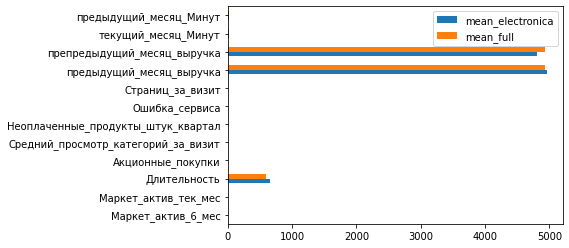

In [200]:
d3.plot(kind = "barh")

(0.0, 30.0)

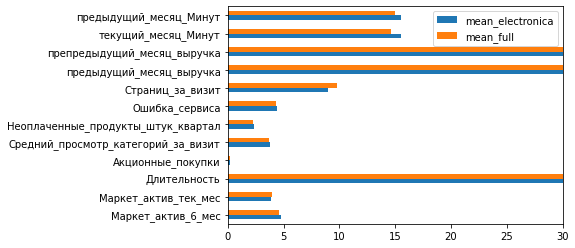

In [201]:
d3.plot(kind = "barh")
plt.xlim(0,30)

(0.0, 1.0)

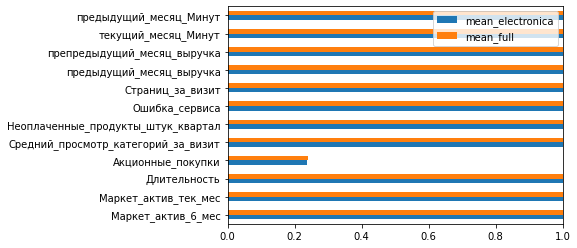

In [202]:
d3.plot(kind = "barh")
plt.xlim(0,1)

Исходя из анализа показателей и графика, можем сделать выовд, что для покупателям электроники нужно придумать какие-то фишки, чтобы они посещали больше страниц за визит, так как этот признак положительно влияет на Покупательскую активность. Также стоит увеличить количество акций для покупателей техники.

### 8.1 Вывод по сегментации

* __Провели анализ сегмента покупателей которые покупают только технику. Исходя из нашего анализа можем предположить, что руководству данного проекта стоит придумать как сделать так, чтобы пользователи из данного сегмента посещали больше страниц за визит, так как этот показатель отстает от показателей пользователей, у которых покупательскаяактивность на прежнем уровне. Возможно стоит придумать какие-то промокоды, которые даются за определенное количество просмотренных страниц, или в сделать карточки товаров меньше, чтобы в целом пользователь видел больше товаров. Также руководителям стоит предлагать полтзователям из данной категории больше акционных предложений, так как доля акционных покупок у них достаточно низкая, а увеличение данного параметраположительно влияет на покупательскую активность.__

##  Шаг 9. Общий вывод

* __Описание задачи:__<br>
    Провести предобработку, исследовательский и кореляционный анализ.Далее нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца .Также выделить сегменты покупателей и разработать для них персонализированные предложения.
<br>
<br>
* __Исходные данные:__<br>
    1. Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. "data_info"
    2. Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. "data_money"
    3. Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода. "data_time"
    4. Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. "data_money_res"
 <br>
 <br>
* __Проведённая предобработка__:<br>
    1. Поменяли названия столбцов, чтобы привести их к единому стилю
    2. Проверили на наличие пропусков в данных(пропуски во всех таблицах отсутствуют)
    3. Проверили на наличие дубликатов в данных(дубликаты во всех таблицах отсутствуют)
    4. Проверили на наличие неявных дубликатов в данных(нашли и преобразовали неявные дубликаты в таблице "data_info", также исправили граматическую ошибку в таблице "data_time" ) в остальных таблицах неявных дубликатов нет
<br>
<br>
* __Поиск лучшей модели__: <br>
    Для поиска лучшей модели использовали пайплайн, в которым были модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC() с различными параметрами, также переберались способы масштабируемости данных, кодирование категариальных признаков происходило с помощью OneHotEncoder. Для посика лучшей комбинации модели и параматров был использован метод RandomizedSearchCV() с 200 итерациями, лучшая модель определялась по метрике "roc_auc".
<br>
<br>
* __Лучшая модель__: <br>
    Лучшей моделью оказалась SVC() с ядром 'rbf' с метрикой "roc_auc" 0.915, однако мы выбрал модель с линейным ядром, чтобы потом можно было визуализировать влияние признаков с помощью библиотеки shap. Таким образом имеем модель SVC() с гипер парамаетрами: 'models__kernel': 'linear' и масштабируемость с помощью MinMax().Результаты по разным метрикам на тестовых данных следующие:
    1. accuracy_score: 0.873
    2. roc_auc_score: 0.847
    3. recall_score: 0.96
    4. precision_score: 0.853
    5. f1_score: 0.904
<br>
<br>
* __Важности признаков__: <br>
    В итоге анализа признаков мы выясняли, что признаки Популярная_категория_Товары для детей , предыдущий_месяц_выручка , Разрешить_сообщать_нет меньше всего влияют на покупательскую активность, а признаки Страниц_за_визит , предыдущий_месяц_Минут , текущий_месяц_Минут больше всего влияют на покупательскую активность
<br>
<br>
* __Сегмент клиентов, которые покупают только технику__: <br>
    Исходя из анализа сегмента покупателей которые покупают только технику можем предположить, что руководству данного проекта стоит придумать как сделать так, чтобы пользователи из данного сегмента посещали больше страниц за визит, так как этот показатель отстает от показателей пользователей, у которых покупательскаяактивность на прежнем уровне. Возможно стоит придумать какие-то промокоды, которые даются за определенное количество просмотренных страниц, или в сделать карточки товаров меньше, чтобы в целом пользователь видел больше товаров. Также руководителям стоит предлагать полтзователям из данной категории больше акционных предложений, так как доля акционных покупок у них достаточно низкая, а увеличение данного параметраположительно влияет на покупательскую активность.

    
    